In [1]:
%matplotlib inline
# use %matplotlib notebook later

import numpy as np
import pandas as pd

from os import path
import random
import re
import unicodedata
import string
import logging

import nltk
# nltk.download(['punkt', 'stopwords', 'wordnet'])     # uncomment if these are not downloaded
from nltk.corpus import stopwords

import gensim
from gensim import corpora, models

from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# local modules
from helper.word_preprocess import DataLoader, CleanText
from helper.embeddings import WordProcess
from helper.text_plot import PlotWordCount
from helper.helper_funs import time_filename, save_folder_file
from methods.LDAprep import GensimPrep, GenMod, Diagnostics, ModelResults

# making a python script of this notebook
!jupyter nbconvert --to script run_LDA.ipynb

[NbConvertApp] Converting notebook run_LDA.ipynb to script
[NbConvertApp] Writing 5768 bytes to run_LDA.py


In [2]:
# `logged = True` produces a log file. Required for convergence plot with LDA.

logged = True
if logged:
    full_path_log = save_folder_file(save_dir='log', filename='', ext='.log')

    logging.basicConfig(filename=full_path_log, 
                      format='%(asctime)s : %(levelname)s : %(message)s', 
                      level=logging.INFO)

In [3]:
random.seed(2018)

# setting for tuning topic number in LDA
eval_every = 2 # the smaller number, the more precise the plot
max_num_topics = 30 # highest number
start = 2 # lowest number
step = 1 # granularity of topic number testing

col = 'Mandate/Mission'  # name of comlumn(s) with text

stop = set(stopwords.words(['english', 'french'])) # words to remove from corpus

stop.update(['art', 'arts', 'artist', 'artists', 'community', 'use', 'make', 'organization']) # hand picked words to remove

In [4]:
d = DataLoader(filename='artbridges_profiles.csv', 
                       data_folder='/data/',
                       colname=['Mandate/Mission'], # column(s) to remove weird chars
                       rm_NAs=True,
                       removed_language=['french']) # list of languages to remove (lowercase)

donnee = d.data_loader()

Removing NAs and duplicates from column Mandate/Mission...

Removing french words...



In [5]:
clean = CleanText(donnee,
                  col=col,
                  stop=stop,
                  stemmer='Porter',
                  remove_urls=True)

processed_data = clean.preprocess()

pd_data = pd.DataFrame({'mission': donnee}) # for using unstemmed text later

Only plain letters kept and words of 3 letters or more.
1 url(s) removed.


In [6]:
wp = WordProcess(processed_data)

word_count = wp.dict_count(verbose=3) # verbose: number of documents to show in output


document #1:
 Counter({'autochton': 5, 'grace': 1, 'mobilit': 1, 'permet': 1, 'aller': 1, 'ver': 1, 'le': 1, 'communaut': 1, 'methodologi': 1, 'pratiqu': 1, 'apprendr': 1, 'creant': 1, 'applique': 1, 'apprentissag': 1, 'cinema': 1, 'musiqu': 1, 'wapikoni': 1, 'developp': 1, 'compet': 1, 'artistiqu': 1, 'techniqu': 1, 'social': 1, 'professionnel': 1, 'contribu': 1, 'ainsi': 1, 'amelior': 1, 'sant': 1, 'global': 1, 'jeun': 1, 'diffus': 1, 'oeuvr': 1, 'realis': 1, 'fait': 1, 'entendr': 1, 'voix': 1, 'jeuness': 1, 'cree': 1, 'pont': 1, 'entr': 1, 'non': 1})


document #2:
 Counter({'space': 2, 'goal': 1, 'becom': 1, 'self': 1, 'sustain': 1, 'retail': 1, 'sale': 1, 'grassroot': 1, 'particip': 1, 'social': 1, 'enterpris': 1, 'welcom': 1, 'divers': 1, 'popul': 1, 'includ': 1, 'margin': 1, 'class': 1, 'sexual': 1, 'gender': 1, 'race': 1, 'cultur': 1, 'disabl': 1, 'mental': 1, 'health': 1, 'addict': 1})


document #3:
 Counter({'media': 2, 'non': 1, 'profit': 1, 'base': 1, 'citi': 1, 'yellowkn

In [7]:
print('These are the 10 most common terms:')
word_count.most_common(10)

These are the 10 most common terms:


[('youth', 137),
 ('cultur', 121),
 ('creativ', 105),
 ('program', 102),
 ('develop', 101),
 ('peopl', 98),
 ('provid', 95),
 ('creat', 93),
 ('work', 89),
 ('support', 80)]

In [8]:
print('Some of the least common, to check lower tail look normal:')
word_count.most_common()[:-10-1:-1] 

Some of the least common, to check lower tail look normal:


[('broad', 1),
 ('up', 1),
 ('urbanart', 1),
 ('attain', 1),
 ('necessari', 1),
 ('curatori', 1),
 ('mid', 1),
 ('exposur', 1),
 ('foremost', 1),
 ('boundari', 1)]

In [9]:
raw_count = WordProcess(donnee).count_words()
num_words = sum(list(word_count.values())) # list() optional, depending on python version - ML


print("There are {} words in the combination of all mission statements.".format(raw_count))
print("There are {} words in all statements given (after preprocess).".format(num_words))

There are 17562 words in the combination of all mission statements.
There are 9845 words in all statements given (after preprocess).


In [10]:
view_data = PlotWordCount(word_count)

view_data.freq_plot(top_n=60) # top_n number of top words to show

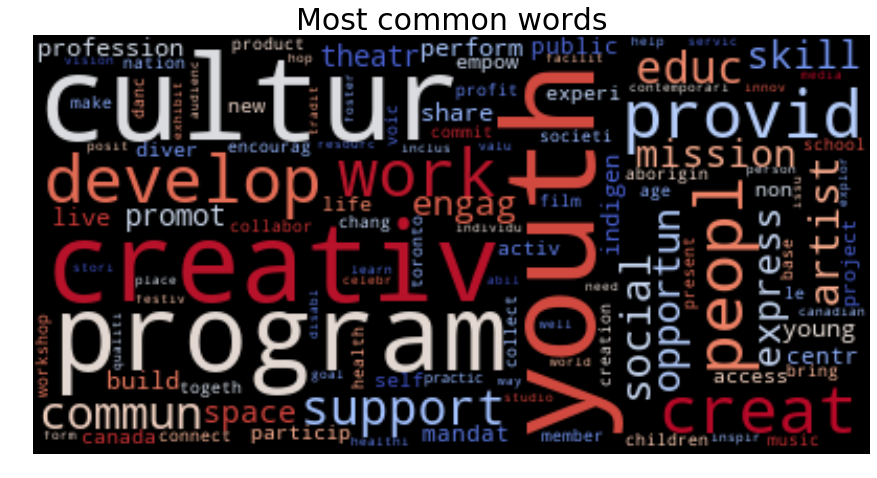

<Figure size 432x288 with 0 Axes>

In [11]:
view_data.cloud_plot(size=(15,12), 
                     max_font_size=60,
                     min_font_size=5);

In [12]:
gp = GensimPrep(processed_data)

Removing words of less than 3 characters, and words present in at least 0.7% of documents

Removing gaps in indices caused by preprocessing...



In [13]:
lda_dict = gp.gensimDict()

Removing words of less than 3 characters, and words present in at least 0.7% of documents

Removing gaps in indices caused by preprocessing...

Directory does not exist, creating a new directory named corpus_data/2018-11-15...

Saving gensim dictionary to corpus_data/2018-11-15/Gensim_dict_Params_RETrue_MWL3_PD0.7__2h57m19s.dict



In [14]:
print('Number of words processed: {}\n '.format(lda_dict.num_pos))
lda_id = lda_dict.token2id
print('Number of unique words: {}\n'.format(max(lda_id.values())))

Number of words processed: 9845
 
Number of unique words: 630



In [15]:
bow_rep = gp.gensimBOW()

Removing words of less than 3 characters, and words present in at least 0.7% of documents

Removing gaps in indices caused by preprocessing...

Saving .mm matrix to corpus_data/2018-11-15/BOWmat_2h57m19s.mm



In [16]:
gp.printBOWfreq(lda_dict, num=21)

gp.printBOWfreq(lda_dict, num=25)

The 21th statement has no words after preprocess.

In the 25th statement, the word... 

"non" appears 1 time(s).
"cultur" appears 1 time(s).
"canada" appears 1 time(s).
"profit" appears 1 time(s).
"commun" appears 1 time(s).
"peopl" appears 1 time(s).
"work" appears 1 time(s).
"chang" appears 1 time(s).
"experi" appears 1 time(s).
"life" appears 1 time(s).
"empow" appears 1 time(s).
"dramat" appears 1 time(s).
"process" appears 1 time(s).
"reflect" appears 1 time(s).


In [17]:
tfidfTrans = gp.tfidf_trans()

get_model = GenMod(bow_rep, lda_dict)

get_tfidf = GenMod(tfidfTrans, lda_dict)

lda_model = get_model.LDA(eval_every=eval_every)

Running LDA model...

Parameters used in model: 
Number of topics: 10
TFIDF transformation: False
Number of iterations: 10000
Batch size: 50
Update every 1 pass
Number of passes: 10
Topic inference per word: True
Alpha: auto
Evaluate every: 2

Directory does not exist, creating a new directory named saved_models/LDA/2018-11-15...

Saving LDA model to: 
saved_models/LDA/2018-11-15/LDA_Params_NT10_TFIDFFalse_Iter10000_Chunk50_Update1_Pass10_Per_word_topicTrue_Alphaauto_Eval2__2h57m22s.model


In [18]:
lsi_model = get_model.LSI()

Running LSI model...

Parameters used in model:
Number of topics: 10
TFIDF transformation: False

Directory does not exist, creating a new directory named saved_models/LSI/2018-11-15...

Saving LSI model to: 
saved_models/LSI/2018-11-15/LSI_Params_NT10_TFIDFFalse__2h57m22s.model



In [19]:
hdp_model = get_model.HDP()

Inferring number of topics with Hierarchical Dirichlet Process...

Parameters used in model:
TFIDF transformation: False

Directory does not exist, creating a new directory named saved_models/HDP/2018-11-15...

Saving HDP model to: 
saved_models/HDP/2018-11-15/HDP_Params_TFIDFFalse__2h57m23s.model



In [20]:
diag = Diagnostics(lda_dict,
                   bow_rep, 
                   processed_data)

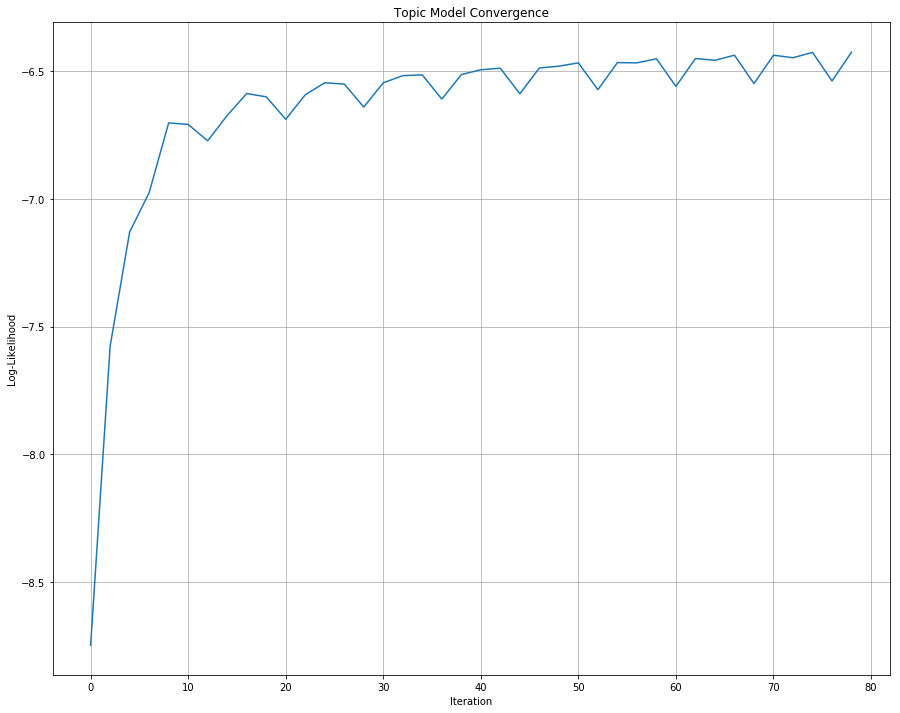

In [21]:
if logged == True:
    diag.convergence_plot(show_plot=True, eval_every=eval_every, log_file=full_path_log)

In [22]:
model_list, res_dict = diag.compare_scores(max_num_topics=max_num_topics, 
                                                          start=start, 
                                                          step=step)

Testing with 2 topics...

Running LDA model...

Testing with 3 topics...

Running LDA model...

Testing with 4 topics...

Running LDA model...

Testing with 5 topics...

Running LDA model...

Testing with 6 topics...

Running LDA model...

Testing with 7 topics...

Running LDA model...

Testing with 8 topics...

Running LDA model...

Testing with 9 topics...

Running LDA model...

Testing with 10 topics...

Running LDA model...

Testing with 11 topics...

Running LDA model...

Testing with 12 topics...

Running LDA model...

Testing with 13 topics...

Running LDA model...

Testing with 14 topics...

Running LDA model...

Testing with 15 topics...

Running LDA model...

Testing with 16 topics...

Running LDA model...

Testing with 17 topics...

Running LDA model...

Testing with 18 topics...

Running LDA model...

Testing with 19 topics...

Running LDA model...

Testing with 20 topics...

Running LDA model...

Testing with 21 topics...

Running LDA model...

Testing with 22 topics...

R

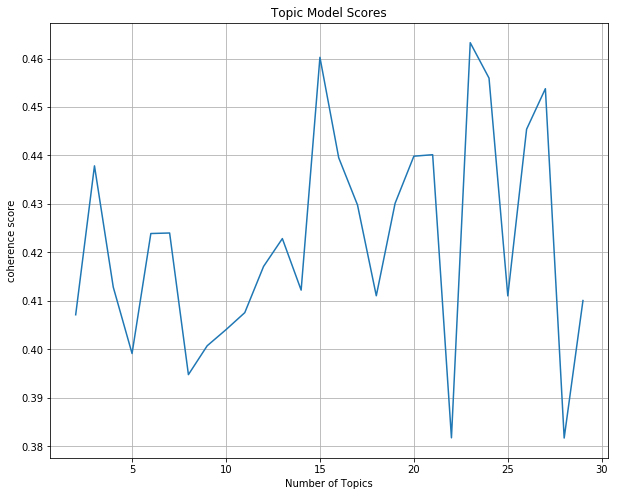

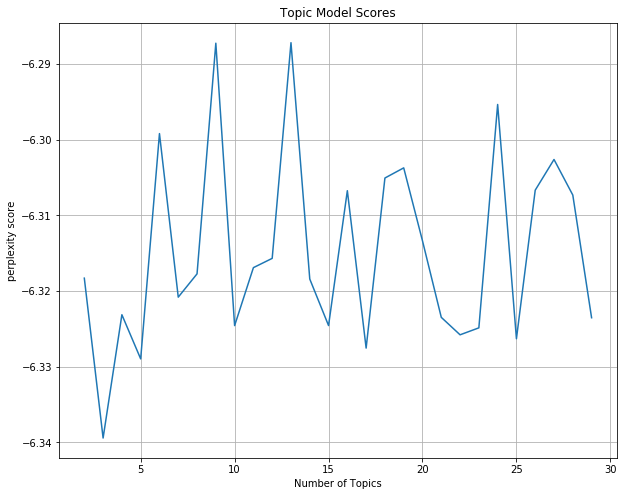

In [23]:
diag.score_plot(res_dict=res_dict, plot_save=False, size=(10, 8))

In [24]:
diag.print_scores(res_dict)

coherence values:

2 topics: 0.4071
3 topics: 0.4379
4 topics: 0.4128
5 topics: 0.3991
6 topics: 0.4239
7 topics: 0.424
8 topics: 0.3948
9 topics: 0.4007
10 topics: 0.4041
11 topics: 0.4076
12 topics: 0.4171
13 topics: 0.4228
14 topics: 0.4122
15 topics: 0.4602
16 topics: 0.4395
17 topics: 0.4298
18 topics: 0.4111
19 topics: 0.4301
20 topics: 0.4399
21 topics: 0.4402
22 topics: 0.3817
23 topics: 0.4633
24 topics: 0.456
25 topics: 0.411
26 topics: 0.4454
27 topics: 0.4538
28 topics: 0.3817
29 topics: 0.4101
	***

perplexity values:

2 topics: -6.3183
3 topics: -6.3394
4 topics: -6.3231
5 topics: -6.329
6 topics: -6.2992
7 topics: -6.3208
8 topics: -6.3177
9 topics: -6.2873
10 topics: -6.3246
11 topics: -6.3169
12 topics: -6.3157
13 topics: -6.2872
14 topics: -6.3184
15 topics: -6.3246
16 topics: -6.3067
17 topics: -6.3275
18 topics: -6.3051
19 topics: -6.3037
20 topics: -6.3134
21 topics: -6.3235
22 topics: -6.3258
23 topics: -6.3249
24 topics: -6.2954
25 topics: -6.3263
26 topics: -6.3

In [25]:
# best model in terms of coherence
max_idx = res_dict['coherence'].index(max(res_dict['coherence']))

# Select the model and print the topics
optimal_model = model_list[max_idx]

In [26]:
diag.print_model(optimal_model)

Topic: 1 
Words: 
0.099*"mandat" + 0.086*"urban" + 0.081*"societi" + 0.053*"vision" + 0.035*"mission" + 0.034*"intern" + 0.032*"local" + 0.032*"region" + 0.030*"women" + 0.024*"statement"

Topic: 2 
Words: 
0.048*"cultur" + 0.034*"peopl" + 0.031*"educ" + 0.028*"program" + 0.028*"aborigin" + 0.024*"commun" + 0.023*"young" + 0.022*"youth" + 0.021*"live" + 0.017*"creation"

Topic: 3 
Words: 
0.082*"le" + 0.058*"disabl" + 0.054*"francai" + 0.046*"sustain" + 0.045*"francophon" + 0.043*"found" + 0.041*"diffus" + 0.040*"communaut" + 0.031*"leur" + 0.027*"promouvoir"

Topic: 4 
Words: 
0.103*"danc" + 0.042*"inclus" + 0.036*"associ" + 0.032*"venu" + 0.031*"passion" + 0.027*"graffiti" + 0.027*"vie" + 0.026*"action" + 0.025*"break" + 0.021*"team"

Topic: 5 
Words: 
0.061*"youth" + 0.058*"provid" + 0.035*"work" + 0.034*"develop" + 0.033*"product" + 0.029*"opportun" + 0.028*"perform" + 0.024*"support" + 0.024*"artist" + 0.023*"skill"

Topic: 6 
Words: 
0.064*"hip" + 0.050*"transform" + 0.046*"invol

In [27]:
pd_data = pd.DataFrame(data={'mission': donnee})
pd_data.reset_index(inplace=True, drop=True)

mod_res = ModelResults(optimal_model, bow_rep, pd_data)

In [28]:
# Format
df_dominant_topic = mod_res.format_topics_sentences()

df_dominant_topic.head(8)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.5518,"indigen, music, canada, public, mission, innov...",grace a sa mobilite qui lui permet d'aller v...
1,1,9.0,0.3381,"creativ, social, space, build, express, share,...",our goal is to have the space become self-sust...
2,2,4.0,0.5432,"youth, provid, work, develop, product, opportu...",we are a non-profit media arts organization ba...
3,3,6.0,0.5313,"indigen, music, canada, public, mission, innov...",quand on joue-when we play (qoj-wwp) is a non-...
4,4,6.0,0.4693,"indigen, music, canada, public, mission, innov...",white water gallery is a not-for-profit artist...
5,5,1.0,0.2312,"cultur, peopl, educ, program, aborigin, commun...",women
6,6,4.0,0.6371,"youth, provid, work, develop, product, opportu...",(in development):\n\n -to provide appropriat...
7,7,9.0,0.3220,"creativ, social, space, build, express, share,...",to create original physical theatre. to share ...


In [30]:
pyLDAvis.enable_notebook()
# Visualize the topics
vis = pyLDAvis.gensim.prepare(optimal_model, bow_rep, lda_dict)
pyLDAvis.save_html(vis,'results/visualization/LDAviz.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.210933 -0.128002       1        1  27.606129
9     -0.184077  0.006553       2        1  21.684875
4     -0.260090 -0.042451       3        1  20.089218
6     -0.024327  0.300856       4        1   9.202638
0      0.056303  0.194542       5        1   4.566608
7      0.105818 -0.102237       6        1   4.094982
5      0.115621 -0.059604       7        1   3.603103
8      0.121683 -0.073318       8        1   3.268688
3      0.157309 -0.058285       9        1   3.167668
2      0.122691 -0.038054      10        1   2.716096, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
134   Default   56.000000      theatr   56.000000  30.0000  30.0000
88    Default   94.000000      provid   94.000000  29.0000  29.0000
101   Default  146.000000       youth  146.000000  28.0000  28.0000
146   Default   40.000000      mandat   40.000000  27.0000  27.0000
415   Default   48.000000     indigen   48.000000  26.0000  26.0000
193   Default   39.000000         new   39.000000  25.0000  25.0000
19    Default  110.000000      cultur  110.000000  24.0000  24.0000
596   Default   31.000000       urban   31.000000  23.0000  23.0000
441   Default   26.000000        danc   26.000000  22.0000  22.0000
192   Default   28.000000        life   28.000000  21.0000  21.0000
518   Default   29.000000     societi   29.000000  20.0000  20.0000
43    Default   52.000000     mission   52.000000  19.0000  19.0000
288   Default   53.000000     product   53.000000  18.0000  18.0000
235   Default   27.000000      vision   27.000000  17.0000  17.0000
89    Default   41.000000      public   41.000000  16.0000  16.0000
85    Default  104.000000       peopl  104.000000  15.0000  15.0000
191   Default   37.000000      experi   37.000000  14.0000  14.0000
15    Default   59.000000      social   59.000000  13.0000  13.0000
81    Default   29.000000       music   29.000000  12.0000  12.0000
10    Default   18.000000          le   18.000000  11.0000  11.0000
66    Default   74.000000        educ   74.000000  10.0000  10.0000
196   Default   60.000000    aborigin   60.000000   9.0000   9.0000
38    Default   35.000000      canada   35.000000   8.0000   8.0000
34    Default   47.000000       space   47.000000   7.0000   7.0000
185   Default   44.000000     perform   44.000000   6.0000   6.0000
585   Default   18.000000         hip   18.000000   5.0000   5.0000
409   Default   17.000000     potenti   17.000000   4.0000   4.0000
123   Default   95.000000     program   95.000000   3.0000   3.0000
62    Default   91.000000     creativ   91.000000   2.0000   2.0000
197   Default   38.000000       activ   38.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
274   Topic10    9.624287  francophon   10.404311   3.5280  -3.1002
174   Topic10    9.201571       found    9.981703   3.5246  -3.1451
5     Topic10    8.810447      diffus    9.590492   3.5211  -3.1885
2     Topic10    8.624941   communaut    9.404944   3.5194  -3.2098
557   Topic10    6.643070        leur    7.423079   3.4950  -3.4709
276   Topic10    5.869748  promouvoir    6.649783   3.4812  -3.5946
27    Topic10    5.359781      margin    6.140217   3.4700  -3.6855
521   Topic10    5.330779    theatral    6.110854   3.4694  -3.6910
178   Topic10    5.092746       nativ    5.873049   3.4634  -3.7366
564   Topic10    4.343724      messag    5.123930   3.4408  -3.8957
555   Topic10    4.094545        afin    4.874553   3.4316  -3.9548
558   Topic10    3.855529        tout    4.635566   3.4217  -4.0149
18    Topic10    3.846113       class    4.626241   3.4213  -4.0174
618   Topic10    3.745512     travail    4.525584   3.4168  -4.0439
33    Topic10    3.176687      sexual    3.956783   3.3864  -4.2086
526   Topic10    3.157135      uphold    3.93